In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from glob import glob
from voxelmorph.generate_edge_map import generate_edge_map

# Dataset definition
class RegistrationDataset(Dataset):
    def __init__(self, pair_txt_dir, transform=None):
        self.pair_txt_paths = sorted(glob(os.path.join(pair_txt_dir, "*", "pair_*.txt")))
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.pair_txt_paths)

    def __getitem__(self, idx):
        txt_path = self.pair_txt_paths[idx]
        with open(txt_path, 'r') as f:
            lines = f.read().splitlines()
            if len(lines) != 2:
                raise ValueError(f"Invalid pair file format: {txt_path}")
            fixed_path, moving_path = lines

        fixed_img = Image.open(fixed_path).convert('L')
        moving_img = Image.open(moving_path).convert('L')

        fixed_tensor = self.transform(fixed_img)
        moving_tensor = self.transform(moving_img)

        moving_edge = generate_edge_map(moving_tensor)
        fixed_edge = generate_edge_map(fixed_tensor)

        return moving_tensor, moving_edge, fixed_tensor, fixed_edge


moving_batch shape: torch.Size([4, 1, 256, 256])
moving_edge_batch shape: torch.Size([4, 1, 256, 256])
fixed_batch shape: torch.Size([4, 1, 256, 256])
fixed_edge_batch shape: torch.Size([4, 1, 256, 256])


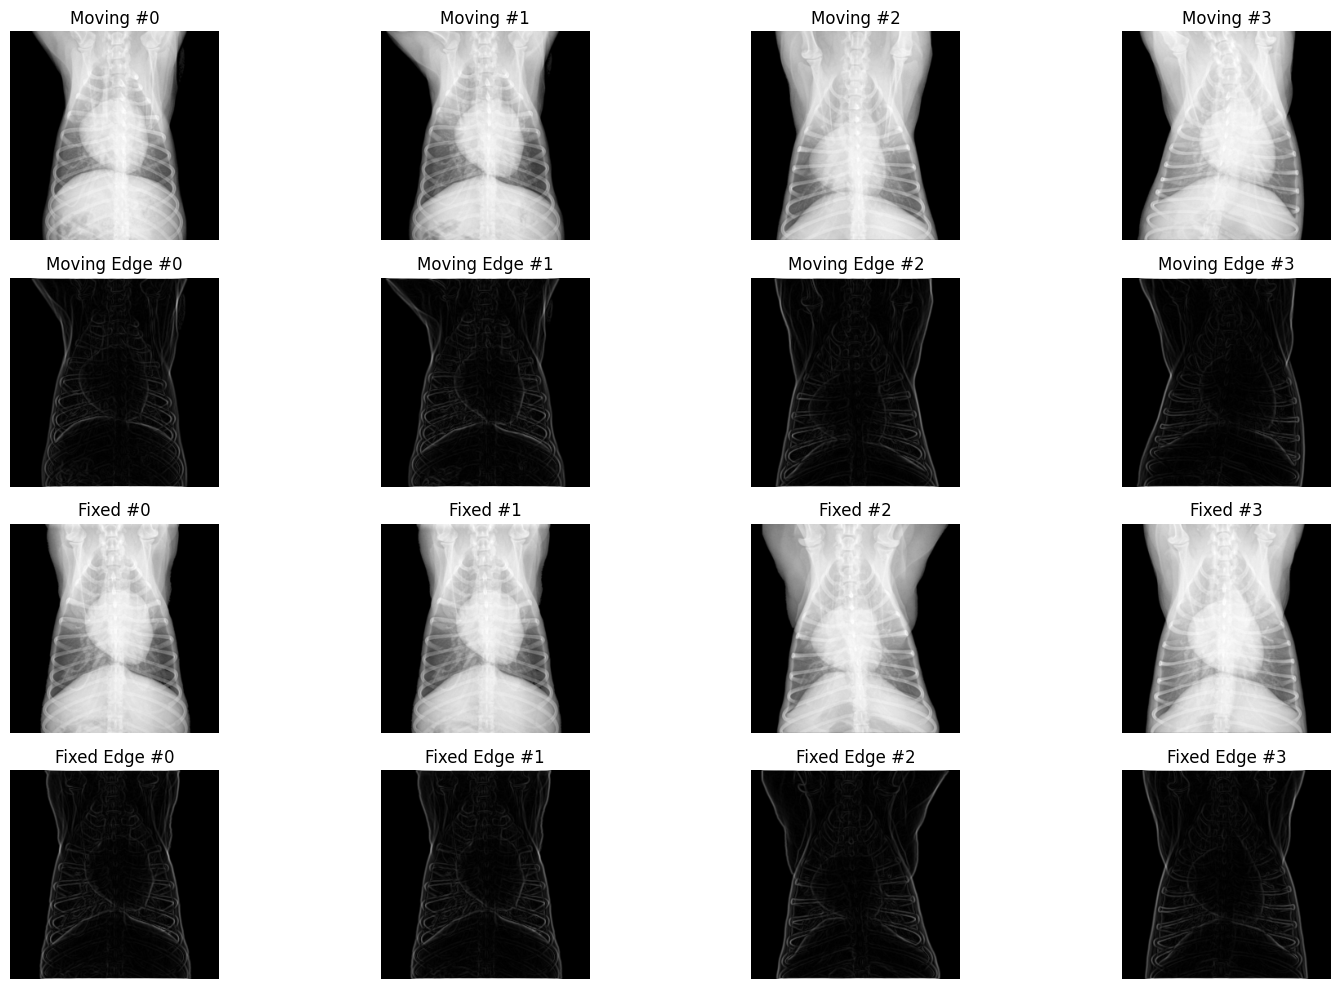

In [ ]:
# 1. Define transforms: resize to 256x256
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 2. Set data paths (sample dataset shipped with this repository)
pair_root_dir = './sample_data/intra-subject cartesian pairs'
pair_txt_dir = os.path.join(pair_root_dir, 'train')

# 3. Dataset and DataLoader
dataset = RegistrationDataset(pair_txt_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 4. Load and inspect one batch
moving_tensor, moving_edge, fixed_tensor, fixed_edge = next(iter(dataloader))

print("Moving tensor shape:", moving_tensor.shape)
print("Moving edge shape:", moving_edge.shape)
print("Fixed tensor shape:", fixed_tensor.shape)
print("Fixed edge shape:", fixed_edge.shape)

# 5. Visualization (Moving / Moving Edge / Fixed / Fixed Edge)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i in range(3):
    axes[0, i].imshow(moving_tensor[i][0].numpy(), cmap='gray')
    axes[0, i].set_title(f'Moving {i}')
    axes[0, i].axis('off')

    axes[1, i].imshow(moving_edge[i][0].numpy(), cmap='gray')
    axes[1, i].set_title(f'Moving Edge {i}')
    axes[1, i].axis('off')

    axes[2, i].imshow(fixed_tensor[i][0].numpy(), cmap='gray')
    axes[2, i].set_title(f'Fixed {i}')
    axes[2, i].axis('off')

    axes[3, i].imshow(fixed_edge[i][0].numpy(), cmap='gray')
    axes[3, i].set_title(f'Fixed Edge {i}')
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()


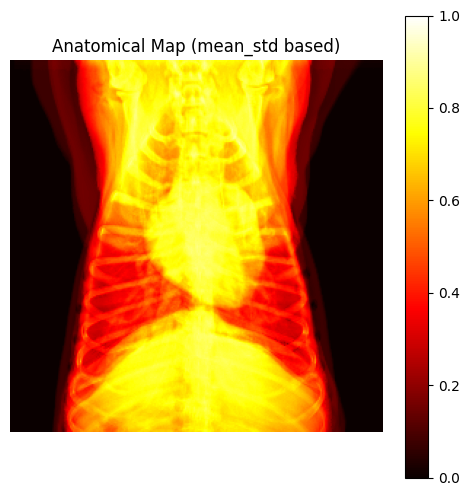

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from voxelmorph.networks import VxmDense, VxmDenseWithRegularization
from voxelmorph.losses import Grad, AnatomyWeightedMSE
from voxelmorph.anatomical_map_generator import compute_anatomical_map

# --- Configuration ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
global_shape = (256, 256)
nb_features_global = [
    [256, 256, 256, 256],
    [256, 256, 128, 64, 32, 16]
]

# --- Build an anatomical map and convert it to a tensor ---
anatomical_map = compute_anatomical_map(
    './sample_data/images/asp_sources',
    image_size=global_shape,
    alpha=1.0,
    visualize=True
)
anatomical_map_tensor = torch.tensor(anatomical_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)


In [ ]:
max_value = anatomical_map_tensor.max().item()
min_value = anatomical_map_tensor.min().item()
mean_value = anatomical_map_tensor.mean().item()
std_value = anatomical_map_tensor.std().item()
median_value = anatomical_map_tensor.median().item()

# --- Print statistics ---
print(f"Max Value: {max_value}")
print(f"Min Value: {min_value}")
print(f"Mean Value: {mean_value}")
print(f"Standard Deviation: {std_value}")
print(f"Median Value: {median_value}")

Max Value: 0.9127745628356934
Min Value: 0.0
Mean Value: 0.39345675706863403
Standard Deviation: 0.3230738937854767
Median Value: 0.43365898728370667


---
## Ablation Study

In [ ]:
from script.train_voxelmorph import train_model
from script.plot_training_logs import plot_training_logs
from voxelmorph.losses import RegistrationLoss
import torch
import os


os.makedirs('./outputs', exist_ok=True)
os.makedirs('./weights', exist_ok=True)

# --- Training setup ---
num_epochs = 100
total_iterations = len(dataloader) * num_epochs

# --- Model factory ---
def build_model():
    return VxmDenseWithRegularization(
        inshape=global_shape,
        nb_unet_features=nb_features_global,
        int_steps=7,
        int_downsize=1,
    ).to(device)

In [ ]:
import torch

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create model
model = build_model()

# Print total number of parameters
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {count_parameters(model)}")

Total parameters: 4453394
Trainable parameters: 4453394


In [14]:
ablation_configs = {
    'voxelmorph-diff': dict(
        use_mse=True,
        use_anatomical_mse=False,
        use_plain_edge=False,
        use_anatomical_edge=False,
        adaptive_mse_transition=False,
        adaptive_edge_transition=False
    )
}



===== Training Case: voxelmorph-diff =====
[Epoch 1]
  Total Loss (Sum)                : 1.1832
    1. Total Primary Loss (Sum)   : 1.1759
      - w_mse * MSE Sum           : 1.1759 (w=1.000, MSE=1.1759)
      - w_anatomy * AnatomyMSE Sum: 0.0000 (w=0.000, AnatomyMSE=0.0000)
      - w_edge_plain * EdgePlain  : 0.0000 (w=0.000, EdgeMSE=0.0000)
      - w_edge_anatomy * EdgeAnatomy: 0.0000 (w=0.000, EdgeMSE=0.0000)
    2. Grad Loss (Sum)            : 0.0073 (w=0.400, Grad=0.0183)
[Epoch 2]
  Total Loss (Sum)                : 0.9151
    1. Total Primary Loss (Sum)   : 0.8614
      - w_mse * MSE Sum           : 0.8614 (w=1.000, MSE=0.8614)
      - w_anatomy * AnatomyMSE Sum: 0.0000 (w=0.000, AnatomyMSE=0.0000)
      - w_edge_plain * EdgePlain  : 0.0000 (w=0.000, EdgeMSE=0.0000)
      - w_edge_anatomy * EdgeAnatomy: 0.0000 (w=0.000, EdgeMSE=0.0000)
    2. Grad Loss (Sum)            : 0.0536 (w=0.400, Grad=0.1341)
[Epoch 3]
  Total Loss (Sum)                : 0.6485
    1. Total Primary Loss

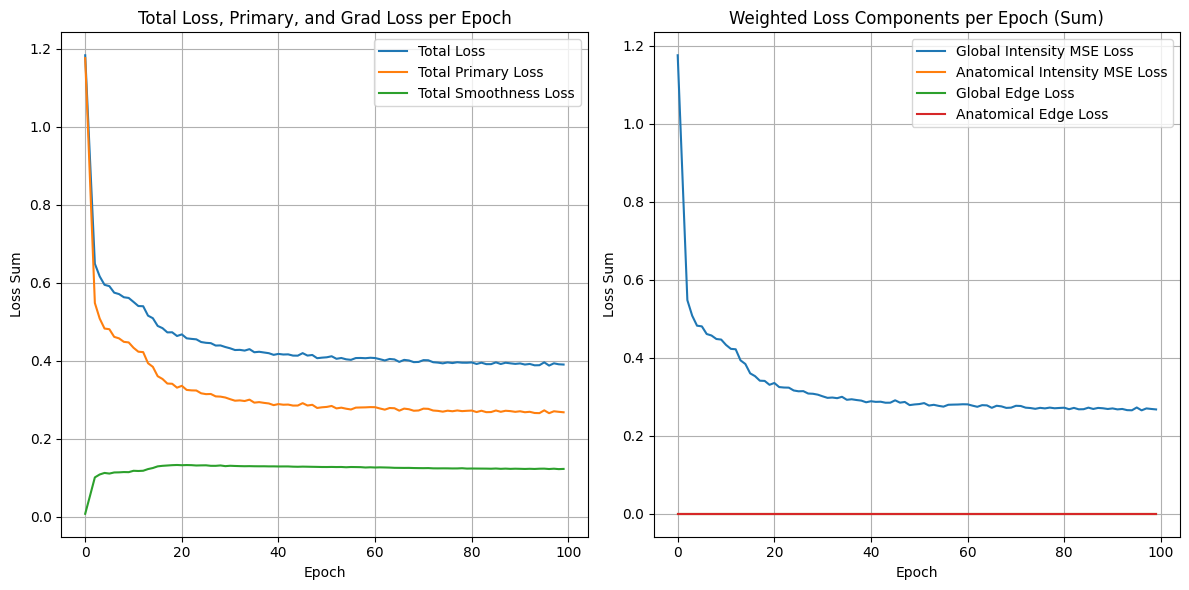

✅ 모델 저장 완료: ./weights/100_case_voxelmorph-diff.pt
✅ 모델 불러오기 완료: Case voxelmorph-diff


C:\Users\dhshs\AppData\Local\Temp\ipykernel_13208\3030187056.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./weights/100_case_{save

In [ ]:
# --- Save Results ---
results_dict = {}

for case_name, config in ablation_configs.items():
    print(f"\n===== Training Case: {case_name} =====")

    # 1. Initialize model and optimizer
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # 2. Initialize loss function
    loss_fn = RegistrationLoss(
        edge_weight=1.0,
        grad_weight=0.4,
        **config
    )

    # 3. Training
    results = train_model(
        model=model,
        loader=dataloader,
        device=device,
        num_epochs=num_epochs,
        loss_fn=loss_fn,
        optimizer=optimizer,
        anatomical_map_tensor_exp=anatomical_map_tensor
    )

    # 4. Save results
    results_dict[case_name] = results

    # 5. Save log plots
    save_case_name = case_name.replace(" ", "_").replace("(", "").replace(")", "")
    plot_training_logs(
        epoch_total_losses=results['epoch_total_losses'],
        epoch_primary_losses=results['epoch_primary_losses'],
        epoch_smooth_losses=results['epoch_grad_component_losses'],
        epoch_mse_component_losses=results['epoch_mse_component_losses'],
        epoch_anatomy_component_losses=results['epoch_anatomy_component_losses'],
        epoch_edge_plain_component_losses=results['epoch_edge_plain_component_losses'],
        epoch_edge_anatomy_component_losses=results['epoch_edge_anatomy_component_losses'],
        save_path=f'./outputs/100_case_{save_case_name}_loss_plot.png'
    )

    # 6. Save model
    torch.save(model.state_dict(), f'./weights/100_case_{save_case_name}.pt')
    print(f"✅ # Model saved successfully: ./weights/100_case_{save_case_name}.pt")

    # 7. Model loading test
    model.load_state_dict(torch.load(f'./weights/100_case_{save_case_name}.pt'))
    model.eval()
    print(f"✅ Model loaded successfully: Case {case_name}")
